# Script Modulação FM

Utilize os sinais de voz masculina e voz feminina disponíveis no SIGAA e gere sinais modulados em frequência. Gere um sinal em banda estreita e um sinal em banda larga. Plote os gráficos da resposta em frequência em todos os casos. Se possível, implemente tudo no mesmo arquivo e plote as curvas dos gráficos sobrepostas.


### Considerações:

* FM banda estreita: $\beta \le 0.2$
* FM banda larga: $\beta \gt 2.0$

---

# Installs / imports

In [255]:
%pip install -q numpy matplotlib scipy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [256]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import butter, sosfiltfilt, resample_poly, hilbert
from scipy.integrate import cumulative_trapezoid

# Portado das referências

In [257]:
def plot_fft(Ts, signal, fmin, fmax, plot_args, x_ticks=5):
    """
    Plots the magnitude spectrum (FFT) of a given time-domain signal.

    Parameters:
    ----------
    Ts : float
        Sampling period (time between samples) in seconds. Defines the time resolution
        and determines the maximum frequency represented in the spectrum.

    signal : numpy.ndarray
        Input signal in the time domain to be transformed into the frequency domain.

    fmin : float
        Minimum frequency (Hz) to display on the x-axis of the plot.

    fmax : float
        Maximum frequency (Hz) to display on the x-axis of the plot.

    plot_args : str or dict
        Arguments passed to matplotlib's plot function for customizing the appearance
        (e.g., color, line style).

    """

    # Zero-padding
    signal = np.concatenate((signal, np.zeros(int(1e6))))

    # FFT and normalize
    ftt = fftshift(np.abs(fft(signal)) / len(signal))

    # Frequency axis
    f = np.linspace(-0.5 / Ts, 0.5 / Ts, len(ftt))

    plt.plot(f, ftt, plot_args)
    plt.axis([fmin, fmax, 0, 1.1 * np.max(ftt)])

    # Set x-axis ticks every X Hz
    tick_step = (fmax - fmin) / x_ticks
    plt.xticks(np.arange(fmin, fmax + tick_step, tick_step))


# Parâmetros Comuns

In [258]:
carrier_frequency = 50e3
carrier_period = 1.0 / carrier_frequency
carrier_amplitude = 1.0

sampling_frequency = 250e3
sampling_period = 1.0 / sampling_frequency

maximum_audio_frequency = 15e3
maximum_audio_amplitude = 1.0

# Carregando os sinais de áudio

In [259]:
def prepare_audio_data(data, original_sample_rate, target_sample_rate = 24000, cutoff_frequency = 15000):
    # Convert signal to mono if stereo
    if data.ndim > 1:
        data = np.mean(data, axis=1)

    # Normalize to float32 range [-1, 1] if necessary
    if data.dtype != np.float32:
        data = data / np.max(np.abs(data), axis=0)

    # Apply low-pass filter
    sos = butter(10, cutoff_frequency / (0.5 * original_sample_rate), btype='low', output='sos')
    filtered = sosfiltfilt(sos, data)

    # Calculate up/down ratio for resampling
    up = int(target_sample_rate)
    down = int(original_sample_rate)
    factor = math.gcd(up, down)
    up //= factor
    down //= factor

    # Resample
    resampled = resample_poly(filtered, up, down)
    return target_sample_rate, resampled.astype(np.float32)

def integrate_audio_signal(signal, sample_rate):
    t = np.arange(len(signal)) / sample_rate
    integrated = cumulative_trapezoid(signal, t, initial=0)
    return integrated

# Load female and male voice signal
female_sample_rate, female_data = wavfile.read('./assets/female_vocal.wav')
male_sample_rate, male_data = wavfile.read('./assets/male_vocal.wav')

# Prepare audio data for FM modulation
female_sample_rate, female_data = prepare_audio_data(female_data, female_sample_rate, sampling_frequency, maximum_audio_frequency)
male_sample_rate, male_data = prepare_audio_data(male_data, male_sample_rate, sampling_frequency, maximum_audio_frequency)

# Integrate audio signals for FM modulation
female_data_integrated = integrate_audio_signal(female_data, female_sample_rate)
male_data_integrated = integrate_audio_signal(male_data, male_sample_rate)

# Generate time vectors for further processing
female_time_vector = np.arange(len(female_data_integrated)) * sampling_period
male_time_vector = np.arange(len(male_data_integrated)) * sampling_period

/tmp/ipykernel_19569/4075832504.py:31: WavFileWarning: Chunk (non-data) not understood, skipping it.
  female_sample_rate, female_data = wavfile.read('./assets/female_vocal.wav')


# Modulação FM

---

## Modulação banda estreita $\beta \le 0.2$

In [260]:
# Narrow band modulation parameters
narrow_beta = 0.2
narrow_kf = narrow_beta * (maximum_audio_frequency / maximum_audio_amplitude)

# FM phase
theta_narrow_female = 2 * np.pi * carrier_frequency * female_time_vector + 2 * np.pi * narrow_kf * female_data_integrated
theta_narrow_male = 2 * np.pi * carrier_frequency * male_time_vector + 2 * np.pi * narrow_kf * male_data_integrated

# Generate narrowband FM signals
narrow_female_fm = carrier_amplitude * np.cos(theta_narrow_female)
narrow_male_fm = carrier_amplitude * np.cos(theta_narrow_male)

## Modulação banda Larga $\beta \gt 2.0$

In [261]:
# Broad band modulation parameters
broad_beta = 2.5
broad_kf = broad_beta * (maximum_audio_frequency / maximum_audio_amplitude)

# FM phase
theta_broad_female = 2 * np.pi * carrier_frequency * female_time_vector + 2 * np.pi * broad_kf * female_data_integrated
theta_broad_male = 2 * np.pi * carrier_frequency * male_time_vector + 2 * np.pi * broad_kf * male_data_integrated

# Generate broad band FM signals
broad_female_fm = carrier_amplitude * np.cos(theta_broad_female)
broad_male_fm = carrier_amplitude * np.cos(theta_broad_male)


## Plots

In [262]:
def plot_fm_analysis(audio_signal, time_vector, fm_signal, title_prefix, beta):
    carrier = carrier_amplitude * np.cos(2 * np.pi * carrier_frequency * time_vector)

    plt.figure(figsize=(12, 10))

    plt.subplot(4, 1, 1)
    plt.plot(time_vector, audio_signal, color='tab:blue')
    plt.title(f'{title_prefix} - Original Audio Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 2)
    plt.plot(time_vector, carrier, color='tab:orange')
    plt.title(f'{title_prefix} - Carrier Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 3)
    plt.plot(time_vector, fm_signal, color='tab:green')
    plt.title(f'{title_prefix} - FM Modulated Signal')
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')

    plt.subplot(4, 1, 4)
    plot_fft(
        sampling_period,
        fm_signal,
        carrier_frequency - ((beta + 1) * maximum_audio_frequency),
        carrier_frequency + ((beta + 1) * maximum_audio_frequency),
        'k',
        x_ticks=10
    )
    plt.title(f'{title_prefix} - FFT of FM Signal')

    plt.tight_layout()
    plt.show()


### Banda estreita (Áudio feminino)

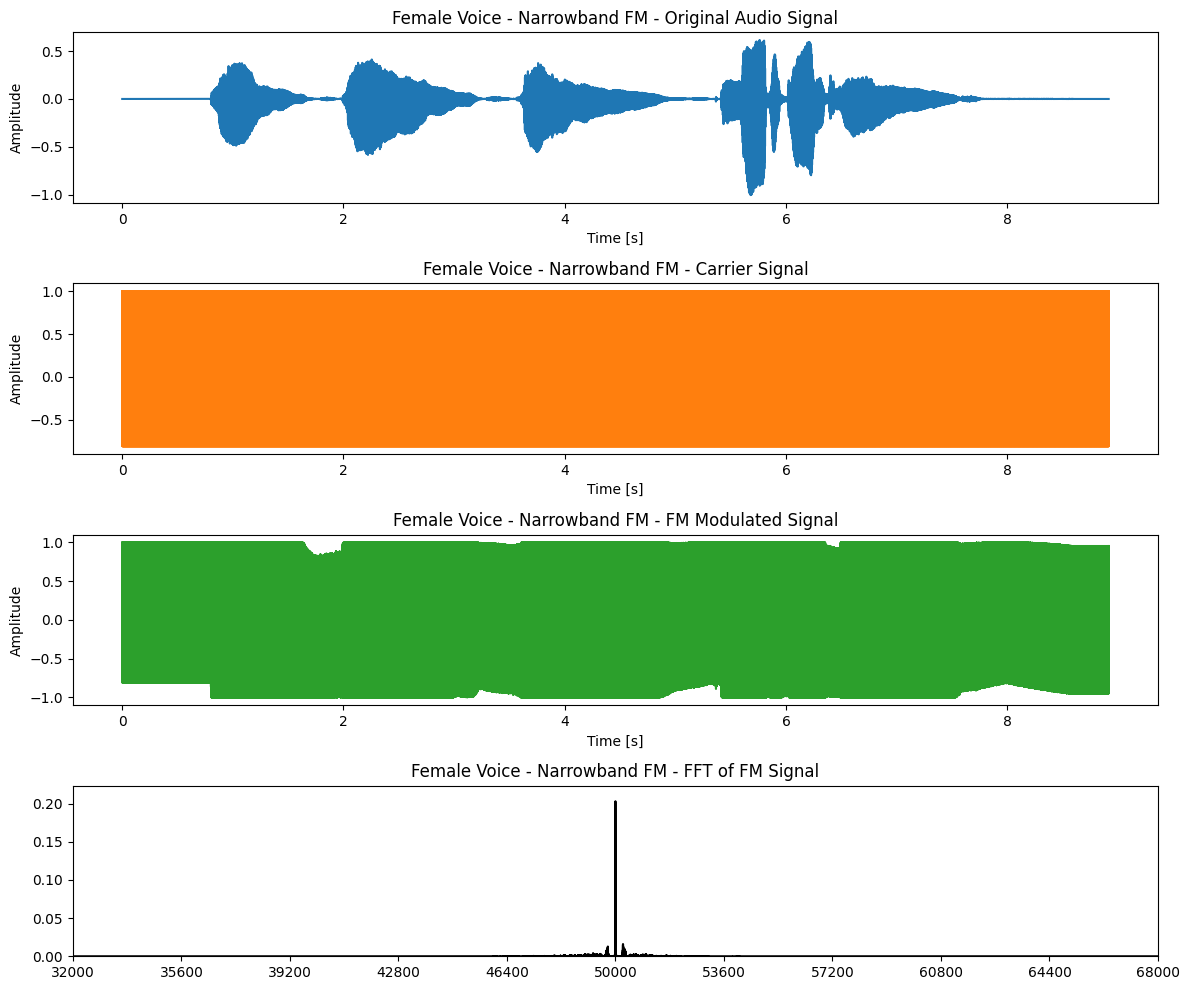

In [263]:
plot_fm_analysis(
    female_data, female_time_vector, narrow_female_fm, "Female Voice - Narrowband FM", narrow_beta
)

### Banda estreita (Áudio masculino)

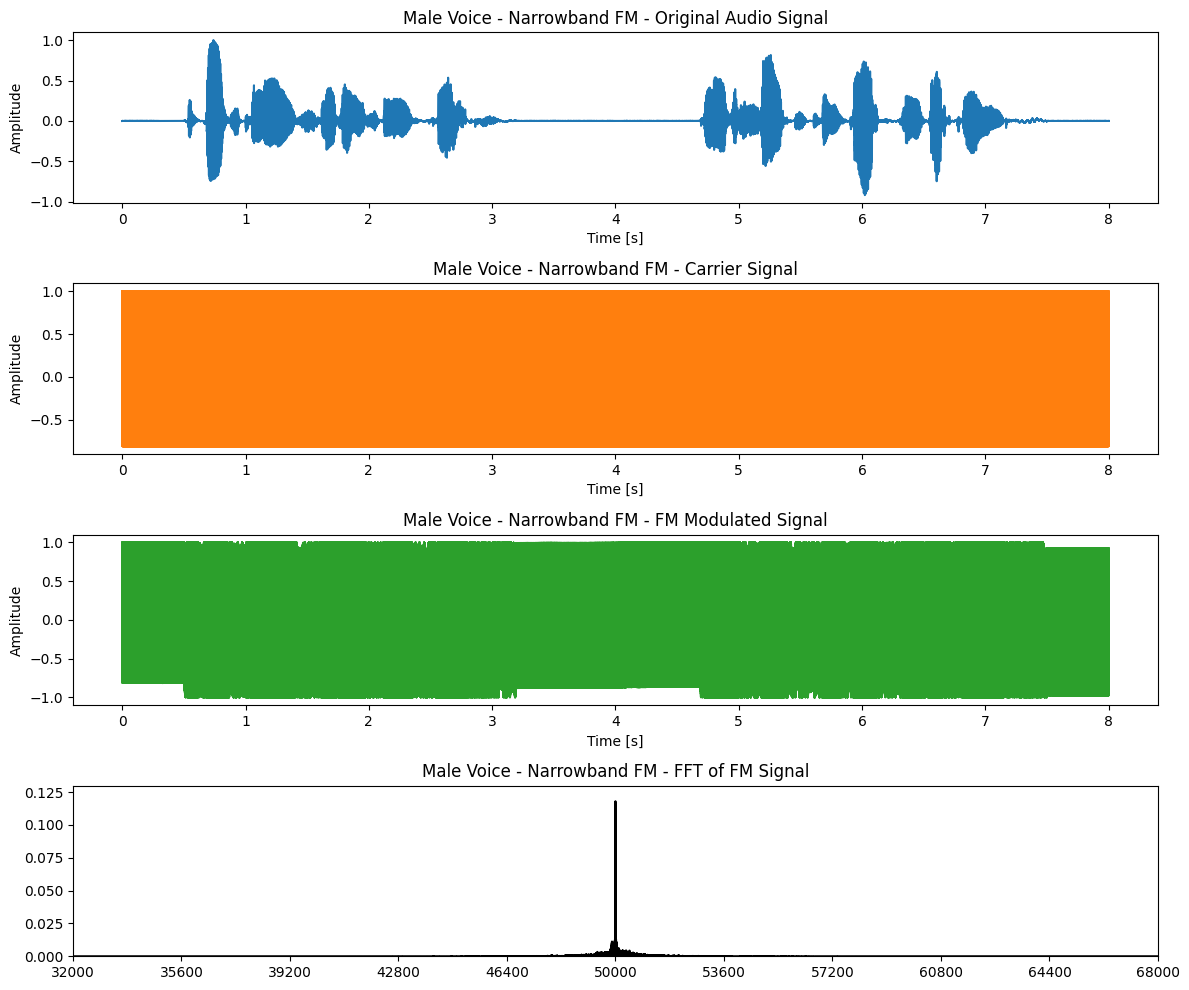

In [264]:
plot_fm_analysis(
    male_data, male_time_vector, narrow_male_fm, "Male Voice - Narrowband FM", narrow_beta
)

### Banda larga (Áudio feminino)

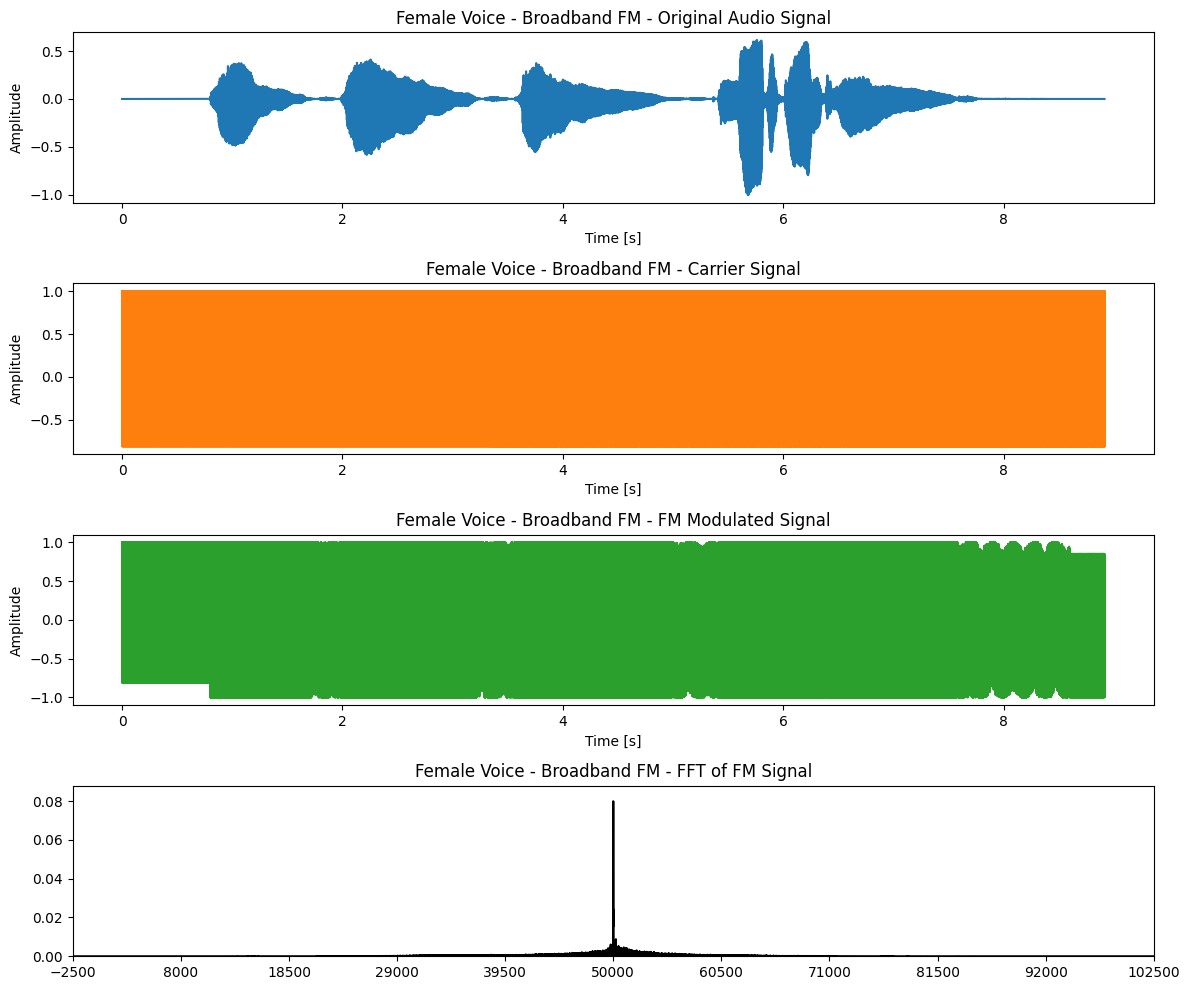

In [265]:
plot_fm_analysis(
    female_data, female_time_vector, broad_female_fm, "Female Voice - Broadband FM", broad_beta
)

### Banda larga (Áudio masculino)

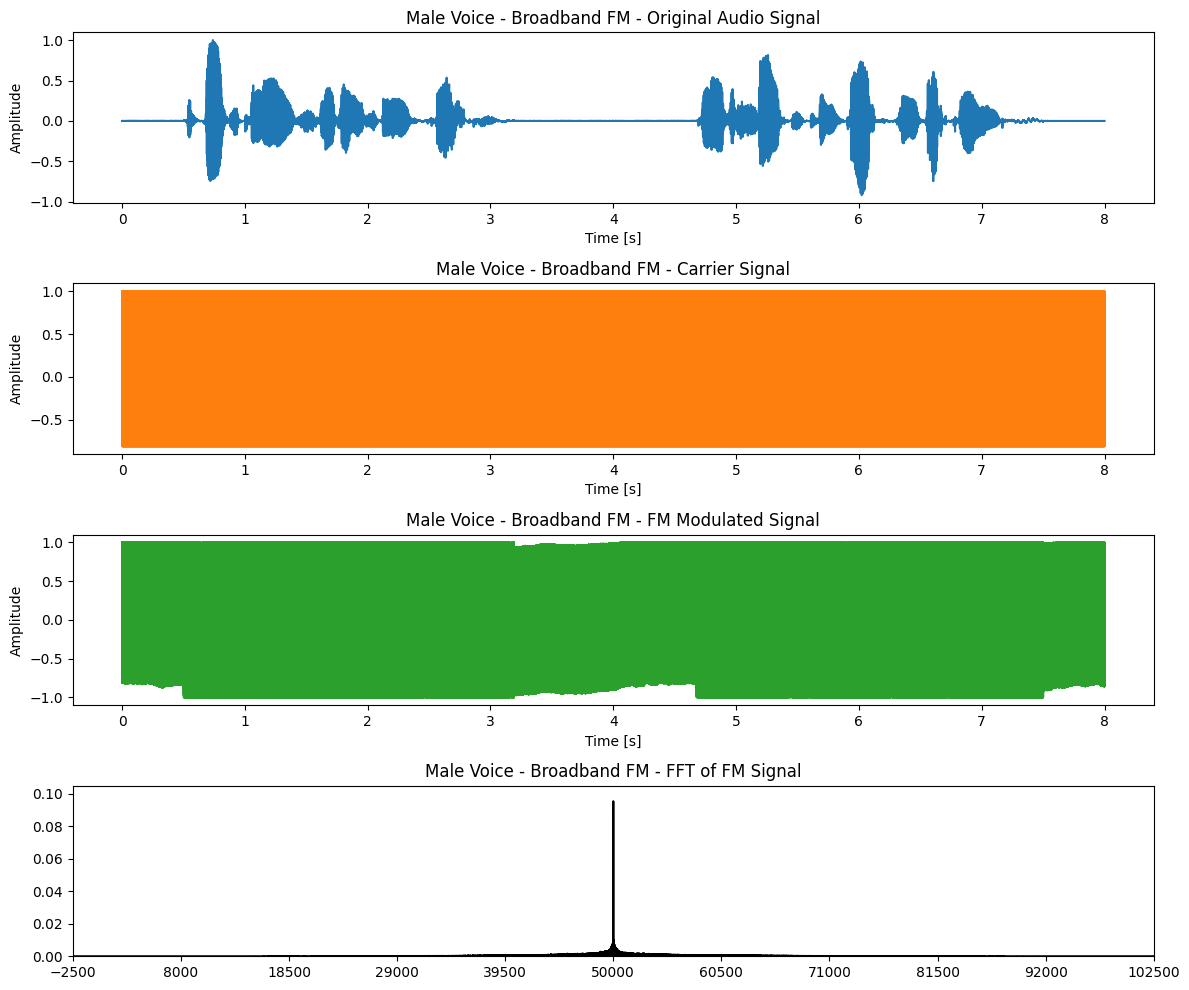

In [266]:
plot_fm_analysis(
    male_data, male_time_vector, broad_male_fm, "Male Voice - Broadband FM", broad_beta
)

# Demodulação FM

---

In [267]:
def demodulate_fm_signal(fm_signal, sampling_period):
    analytic_signal = hilbert(fm_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    demodulated_signal = np.diff(instantaneous_phase) / sampling_period
    demodulated_signal = np.append(demodulated_signal, demodulated_signal[-1])

    return demodulated_signal

# Demodulate the FM signals
demodulated_narrow_female = demodulate_fm_signal(narrow_female_fm, sampling_period)
demodulated_broad_female = demodulate_fm_signal(broad_female_fm, sampling_period)

demodulated_narrow_male = demodulate_fm_signal(narrow_male_fm, sampling_period)
demodulated_broad_male = demodulate_fm_signal(broad_male_fm, sampling_period)

# Remove DC offset
demodulated_narrow_female -= np.mean(demodulated_narrow_female)
demodulated_broad_female -= np.mean(demodulated_broad_female)
demodulated_narrow_male -= np.mean(demodulated_narrow_male)
demodulated_broad_male -= np.mean(demodulated_broad_male)


# Down sample to 48000 Hz and save the demodulated signals
fs1, data1 = prepare_audio_data(demodulated_narrow_female, sampling_frequency, 48000)
fs2, data2 = prepare_audio_data(demodulated_broad_female, sampling_frequency, 48000)

fs3, data3 = prepare_audio_data(demodulated_narrow_male, sampling_frequency, 48000)
fs4, data4 = prepare_audio_data(demodulated_broad_male, sampling_frequency, 48000)

# Save the demodulated signals
wavfile.write('./assets/demodulated/female_narrow.wav', fs1, data1)
wavfile.write('./assets/demodulated/female_broad.wav', fs2, data2)
wavfile.write('./assets/demodulated/male_narrow.wav', fs3, data3)
wavfile.write('./assets/demodulated/male_broad.wav', fs4, data4)


## Plots

In [268]:
def plot_audio_vs_demodulated(original_signal, demodulated_signal, time_vector, title_prefix):
    plt.figure(figsize=(12, 10))

    plt.subplot(4, 1, 1)
    plt.plot(time_vector, original_signal, label="Original")
    plt.title(f"{title_prefix} - Original Audio Signal")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.subplot(4, 1, 2)
    plt.plot(time_vector, demodulated_signal, label="Demodulated", color="orange")
    plt.title(f"{title_prefix} - Demodulated Audio Signal")
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.grid(True)

    plt.subplot(4, 1, 3)
    plot_fft(sampling_period, original_signal, 0, 2 * maximum_audio_frequency, 'b')
    plt.title(f"{title_prefix} - FFT of Original Signal")

    plt.subplot(4, 1, 4)
    plot_fft(sampling_period, demodulated_signal, 0, 2 * maximum_audio_frequency, 'r')
    plt.title(f"{title_prefix} - FFT of Demodulated Signal")

    plt.tight_layout()
    plt.show()


### Comparação anda estreita (Áudio feminino)

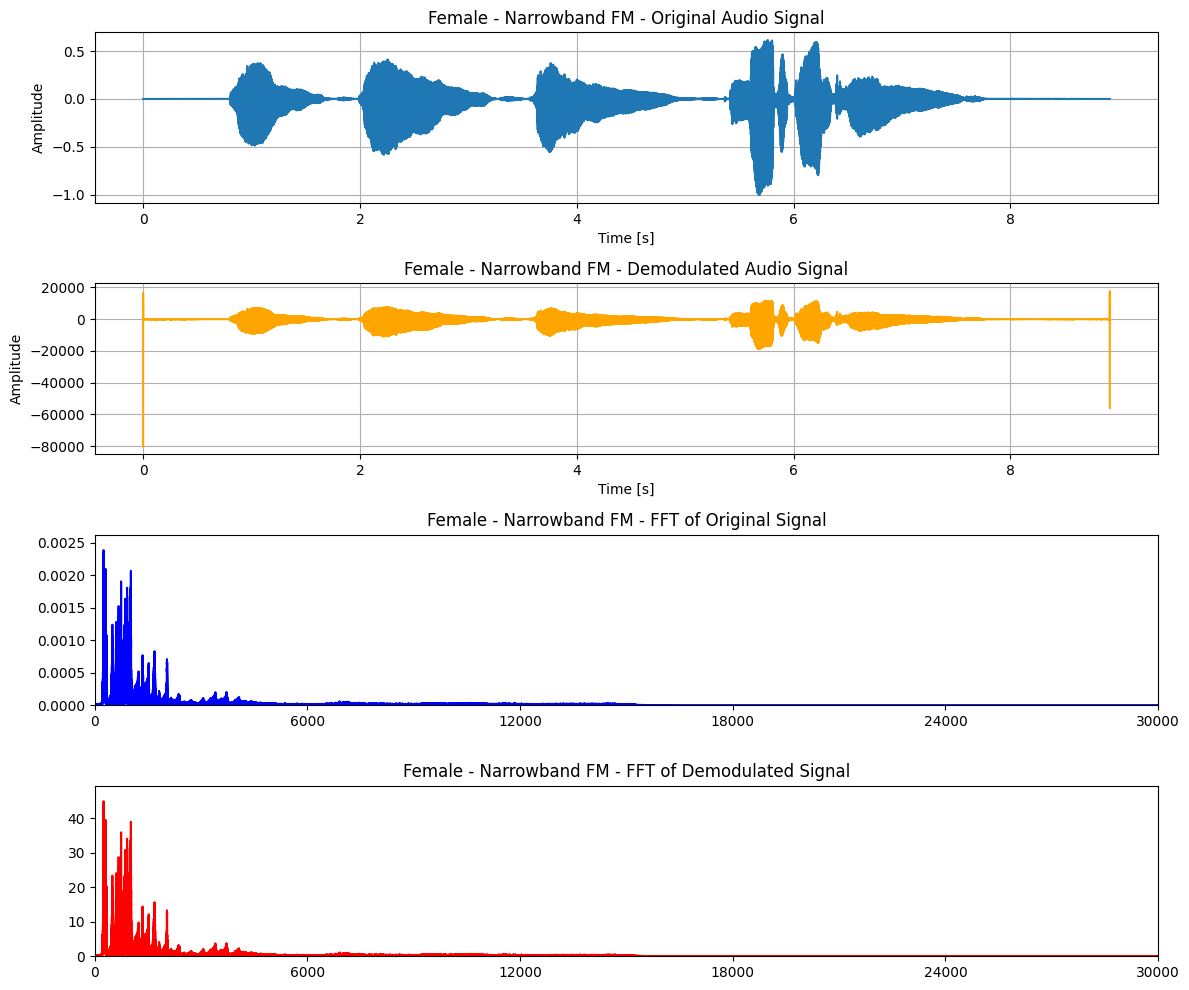

In [269]:
plot_audio_vs_demodulated(
    female_data,
    demodulated_narrow_female,
    female_time_vector,
    title_prefix="Female - Narrowband FM"
)

### Comparação banda estreita (Áudio masuculino)

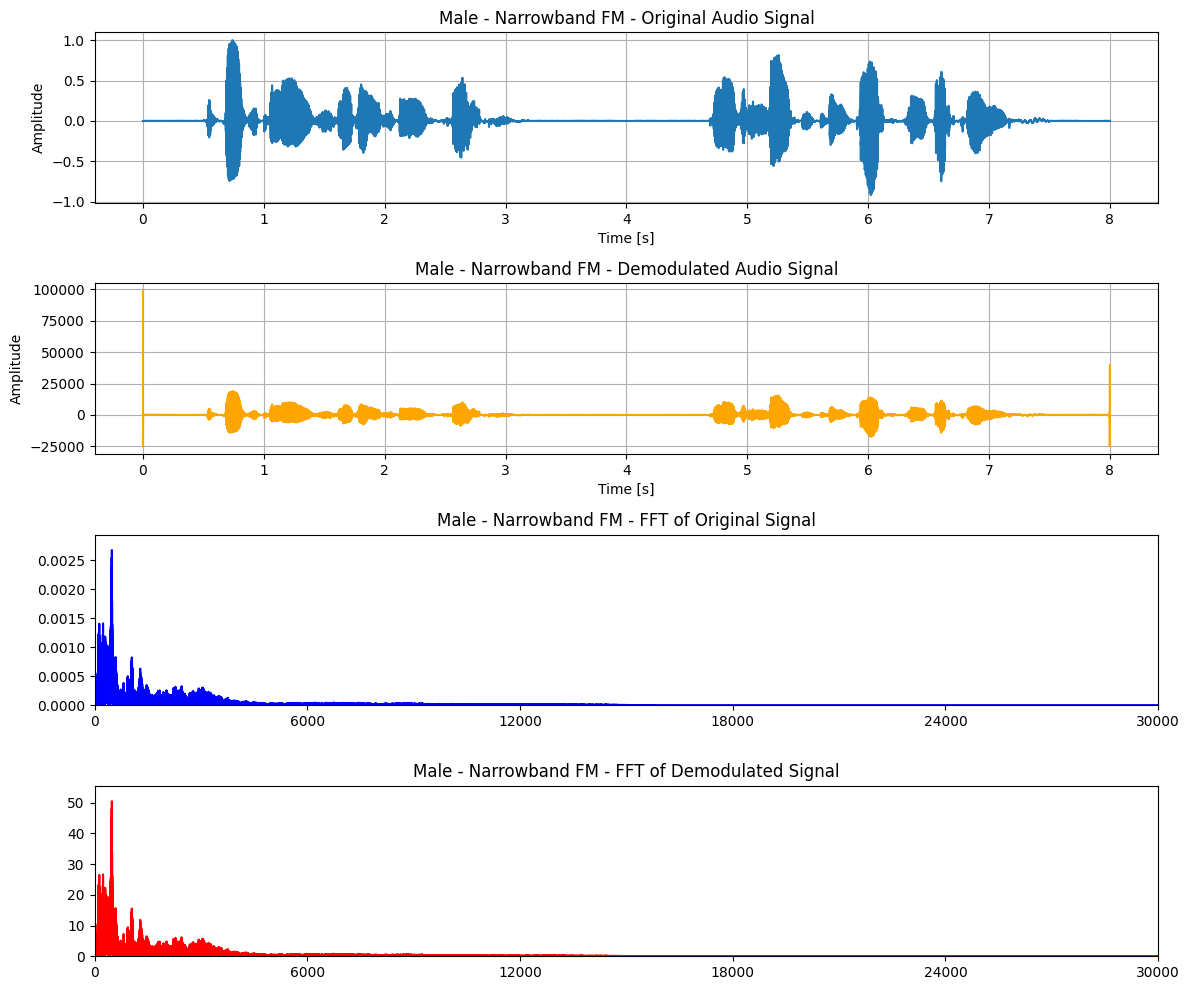

In [270]:
plot_audio_vs_demodulated(
    male_data,
    demodulated_narrow_male,
    male_time_vector,
    title_prefix="Male - Narrowband FM"
)

### Comparação banda larga (Áudio feminino)

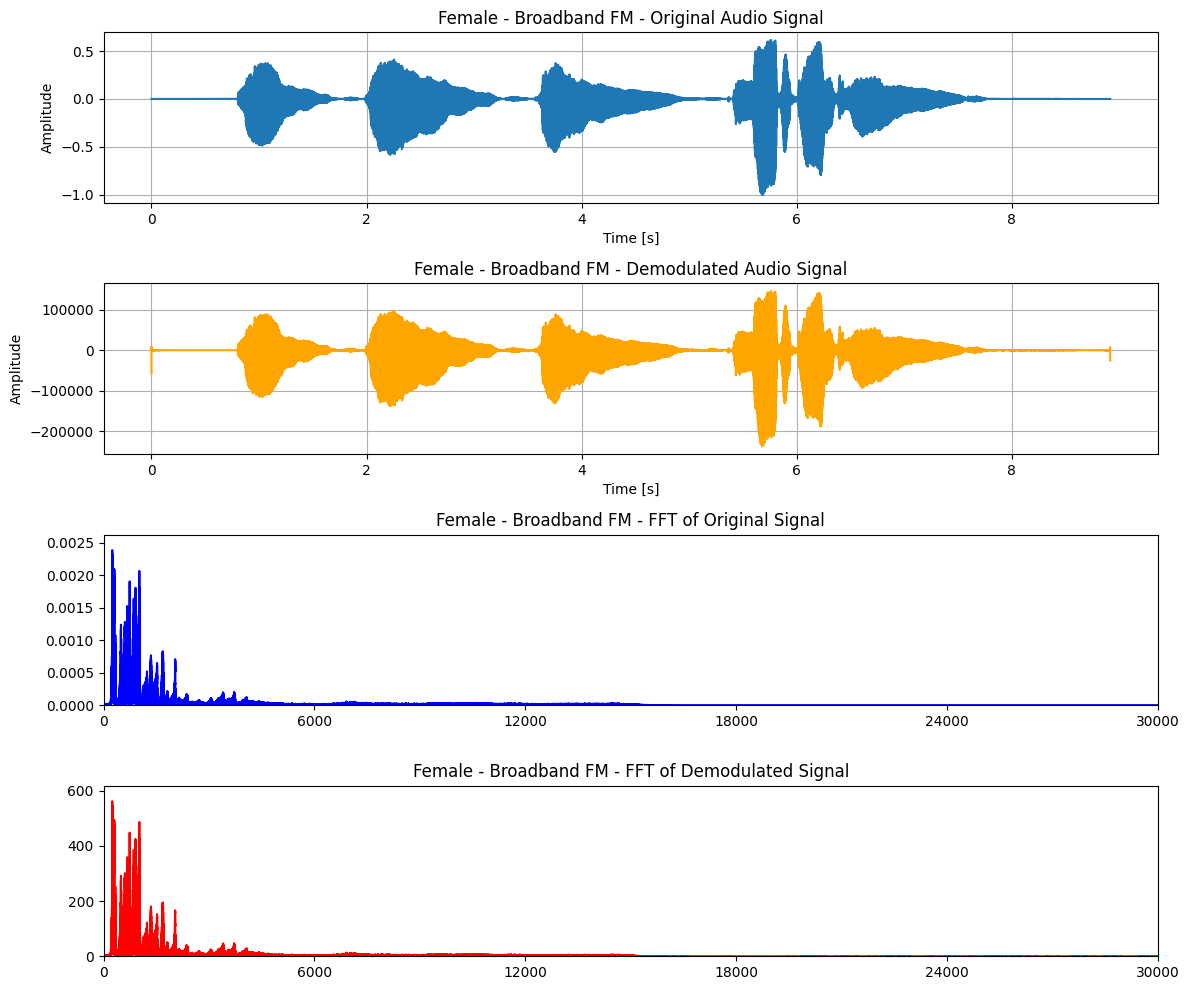

In [271]:
plot_audio_vs_demodulated(
    female_data,
    demodulated_broad_female,
    female_time_vector,
    title_prefix="Female - Broadband FM"
)

### Comparação banda larga (Áudio masuculino)

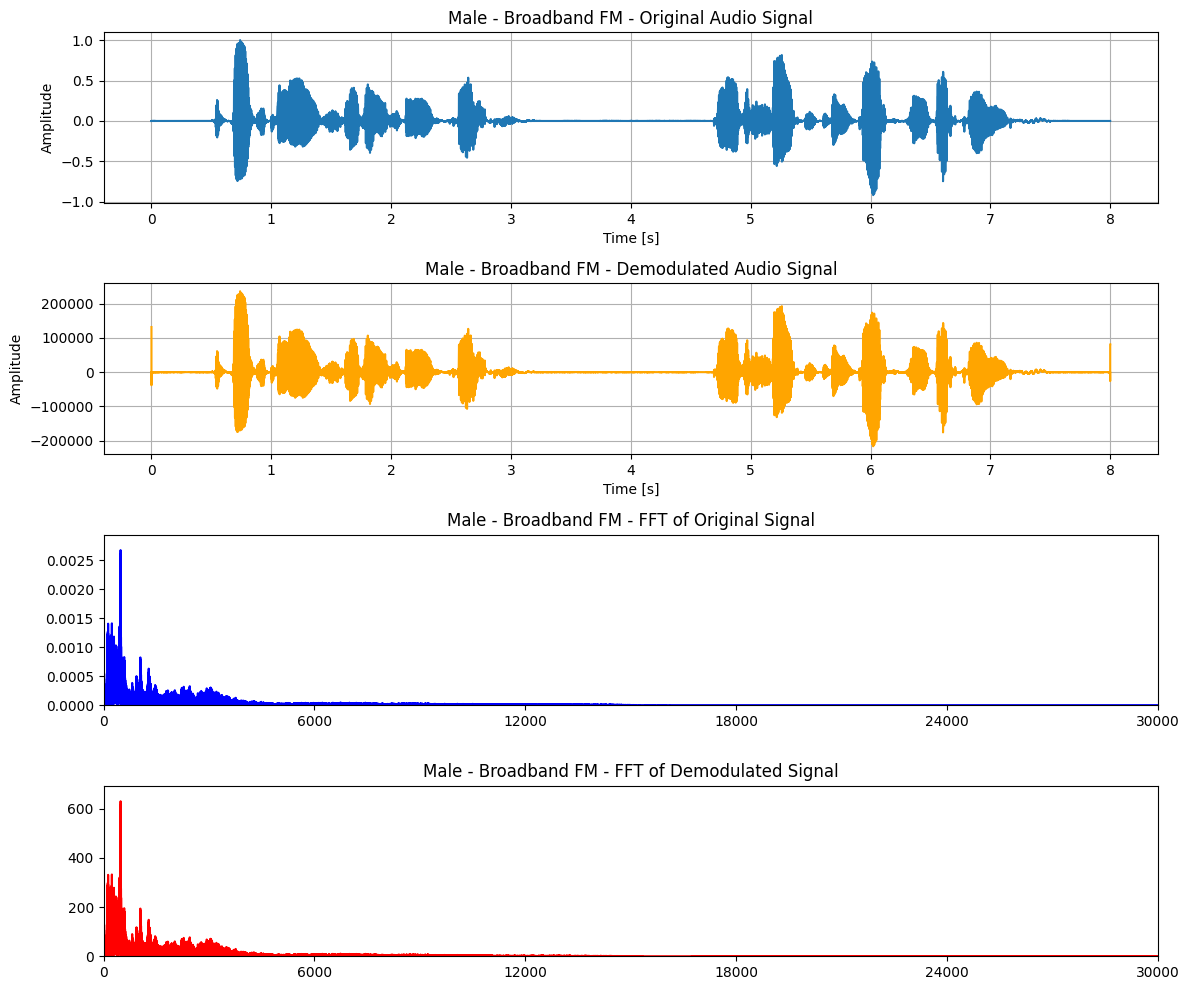

In [272]:
plot_audio_vs_demodulated(
    male_data,
    demodulated_broad_male,
    male_time_vector,
    title_prefix="Male - Broadband FM"
)